# Technical Metadata Feature Selection

The SRA database has a field called `library_strategy` which references the type
of sequencing that was done.
While we expect this field is correct most of the
time, we are concerned that there are instances where a sample is misclassified.
This could occur if the individual uploading to SRA was not familiar with the
project.
Also `library_strategy` is validated against a schema from SRA, making
it possible that when a technology was new individuals would classify it as
`OTHER` because the term was not present in the schema.
Here we try to infer
the technical metadata based on the data.
The first challenge is to identify a
set features that can be used to separate samples from different methods.

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_tech_feature_selection')

# Connect to data store
store = pd.HDFStore('../output/sra.h5')

# Start up dask cluster
client = Client()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-06-27 
Git hash: 4c20d01e6681b8c7b88b8839bd26945d510a9c60


In [2]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sra']
ncbi = db['ncbi']

In [3]:
# Grab list of samples that passed merge
samples = store['prealn/merge_passed']
srxs = samples.srx.unique().tolist()
srrs = samples.srr.unique().tolist()
num_samples = samples.shape[0]
idx = samples.set_index(['srx', 'srr']).index

In [4]:
# Pull out current annotations
db_anno = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srxs}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
])))

anno = {}
for i, _df in db_anno.groupby('library_strategy'):
    if len(_df) > 100:
        anno[i] = _df.srx.tolist()

db_anno.set_index('srx', inplace=True)

In [5]:
_df = db_anno.library_strategy.value_counts().to_frame().applymap(lambda x: '{:,}'.format(x))
_df.columns = ['Number of SRXs']
_df.index.name = 'Library Strategy'
Markdown(f"""
**Current Database Annotations**

{_df.to_html(classes='table table-stripped')}

""")


**Current Database Annotations**

<table border="1" class="dataframe table table-stripped">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Number of SRXs</th>
    </tr>
    <tr>
      <th>Library Strategy</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>RNA-Seq</th>
      <td>10,583</td>
    </tr>
    <tr>
      <th>ChIP-Seq</th>
      <td>2,556</td>
    </tr>
    <tr>
      <th>WGS</th>
      <td>1,802</td>
    </tr>
    <tr>
      <th>OTHER</th>
      <td>1,186</td>
    </tr>
    <tr>
      <th>EST</th>
      <td>279</td>
    </tr>
    <tr>
      <th>Targeted-Capture</th>
      <td>68</td>
    </tr>
    <tr>
      <th>MNase-Seq</th>
      <td>62</td>
    </tr>
    <tr>
      <th>FAIRE-seq</th>
      <td>17</td>
    </tr>
    <tr>
      <th>DNase-Hypersensitivity</th>
      <td>9</td>
    </tr>
    <tr>
      <th>WGA</th>
      <td>6</td>
    </tr>
    <tr>
      <th>ncRNA-Seq</th>
      <td>5</td>
    </tr>
    <tr>
      <th>MeDIP-Seq</th>
      <td>4</td>
    </tr>
    <tr>
      <th>POOLCLONE</th>
      <td>4</td>
    </tr>
    <tr>
      <th>AMPLICON</th>
      <td>4</td>
    </tr>
    <tr>
      <th>RIP-Seq</th>
      <td>1</td>
    </tr>
    <tr>
      <th>miRNA-Seq</th>
      <td>1</td>
    </tr>
  </tbody>
</table>



## Feature Selection

The pre-alignment workflow runs a battery of tools that could be useful for
classifying samples based on library strategy.
Here I look at various features
created by these tools and identify a feature set to use for library strategy
classification.

In [6]:
def make_plot(df, column, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    sns.kdeplot(df[column], shade=True, label='all', lw=3, ax=ax)
    for i, _df in df.join(db_anno, how='left').groupby('library_strategy'):
        if len(_df) > 100:
            sns.kdeplot(_df[column], label=i, lw=3, ax=ax)
    ax.legend()
    ax.set_title(column)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, .95])

### Feature Counts

The first metric I look at how well reads are mapped to
genomic features.
For datasets like RNA-Seq and ESTs I expect that most reads
go to a genomic feature, while things like WGS and ChIP-Seq will have a lower
percentage mapped to a feature.

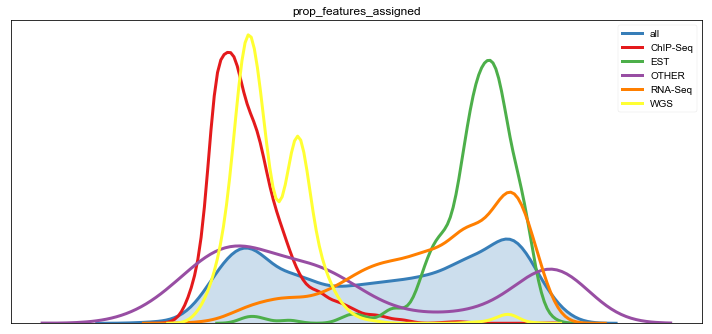

In [7]:
total = store.select('prealn/workflow/feature_counts/summary', 'srr == srrs').sum(axis=1)
feature_assigned = store.select('prealn/workflow/feature_counts/summary', 'srr == srrs')['Assigned'].to_frame()
feature_assigned['total'] = total
feature_assigned = feature_assigned.groupby(level='srx').sum()
feature_assigned['prop_features_assigned'] = feature_assigned.Assigned / feature_assigned.total
feature_assigned.drop(['Assigned', 'total'], axis=1, inplace=True)

make_plot(feature_assigned, 'prop_features_assigned')

### Picard Collect RNA-Seq Metrics

Next I used the Picard CollectRNASeqMetrics
tool, which provides a number of useful metrics including summarizing where
reads are mapping (i.e., Coding, UTR, Intronic, Intergenic).
For RNA-Seq and
EST I expect that reads are mapped to UTR and coding regions with little
coverage in the introns and intergenic regions.
While technologies like WGS and
ChIP-Seq may will have increased intronic and intergenic coverage.

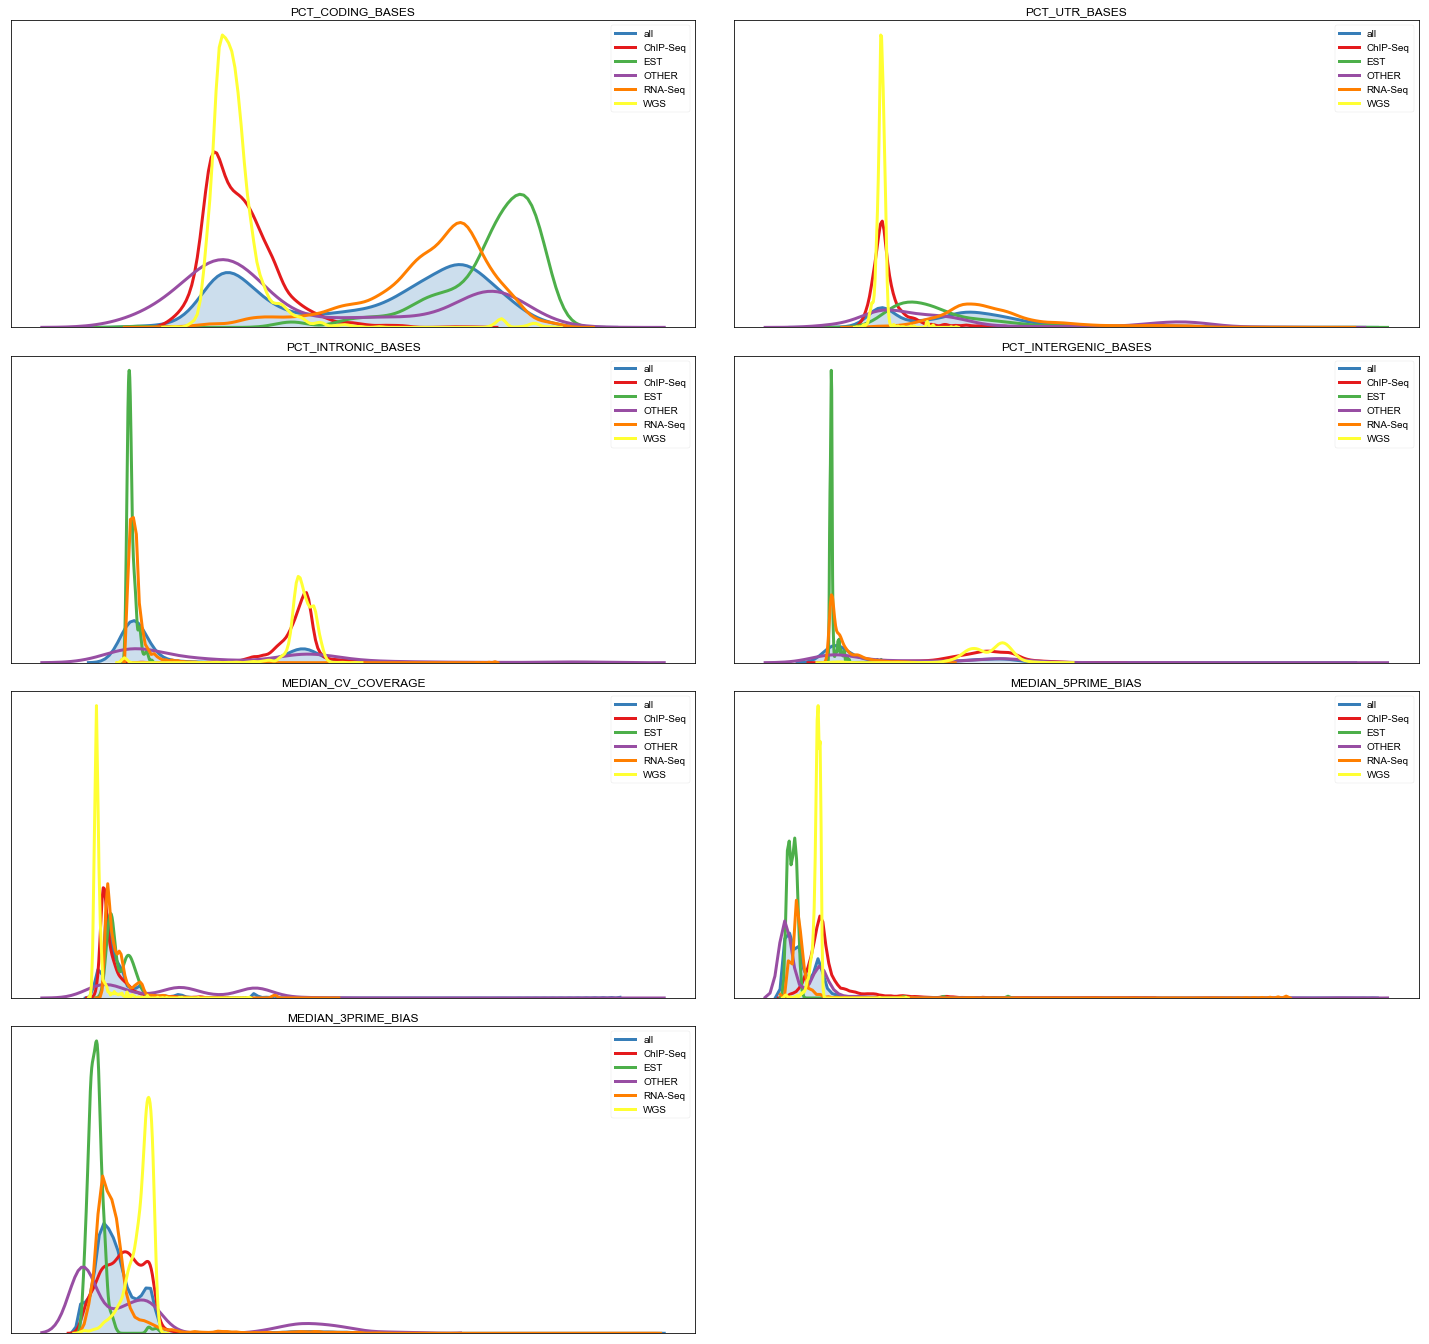

In [8]:
picard_cols = ['PCT_CODING_BASES', 'PCT_UTR_BASES', 'PCT_INTRONIC_BASES', 'PCT_INTERGENIC_BASES', 'MEDIAN_CV_COVERAGE', 'MEDIAN_5PRIME_BIAS', 'MEDIAN_3PRIME_BIAS']
picard_collect = store.select('prealn/workflow/collectrnaseqmetrics/unstranded', 'srr == srrs')[picard_cols]
picard_collect = picard_collect.groupby(level='srx').mean()

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(picard_cols):
    make_plot(picard_collect, col, axes[i])
axes[-1].set_visible(False)

CollectRNASeqMetrics also calculates the gene body coverage over normalized
positions. There are distinct patterns of difference of coverage across the gene
body as show in the cluster map below.

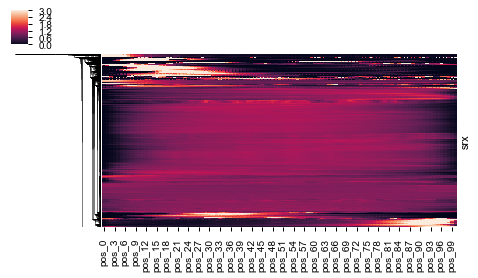

In [9]:
sns.clustermap(store['prealn/workflow/collectrnaseqmetrics/genebody'].groupby('srx').median(), 
               robust=True, yticklabels=False, col_cluster=False, figsize=plt.figaspect(1/2));

In [10]:
from scipy.stats import variation as cv

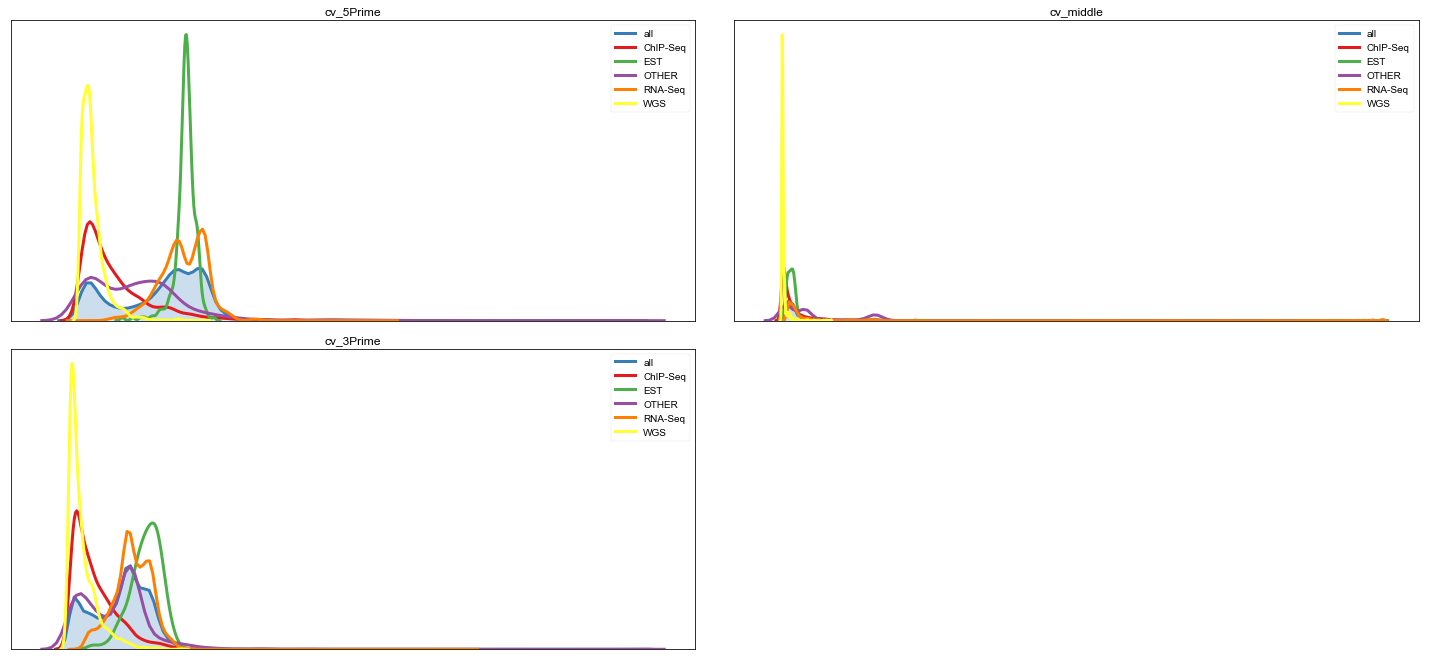

In [11]:
gb_by_srx = store.select('prealn/workflow/collectrnaseqmetrics/genebody', 'srr == srrs').groupby('srx').median()

# make sure no missing
assert gb_by_srx.isna().sum().sum() == 0

# Add a really small value so 0's behave
gb_by_srx = gb_by_srx + 0.000001

# split positions into bins
_5Prime = gb_by_srx.iloc[:, :21]
_3Prime = gb_by_srx.iloc[:, -21:]
_middle = gb_by_srx.iloc[:, 21:-21]

# Calculate the coefficient of variation for each bin
_5Prime_cv = _5Prime.apply(cv, axis=1)
_3Prime_cv = _3Prime.apply(cv, axis=1)
_middle_cv = _middle.apply(cv, axis=1)

# Munge and make plots
gb_cv = pd.concat([_5Prime_cv, _middle_cv, _3Prime_cv], axis=1)
gb_cv.columns = ['cv_5Prime', 'cv_middle', 'cv_3Prime']

from itertools import zip_longest
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
for ax, col in zip_longest(axes, gb_cv.columns):
    if col is None:
        continue
    make_plot(gb_cv, col, ax=ax)

axes[-1].set_visible(False)

### Picard Markduplicates

I also ran Picard Markduplicates.
Markduplicates
identifies reads that are sequence duplicates.
Sequence duplicates are commonly
caused by PCR artifact, optical duplicates during sequencing, or extremely high
coverage libraries.
Typically I would expect that ChIP-Seq libraries, where you
are enriching for a small sequence foot print, would have highest sequence
duplicates.
Interestingly, the plot below does not show this trend, but has RNA-
Seq and EST having the highest sequence duplication rate.
One possible
explanation is that ChIP-Seq workflows tend to remove duplicates, and it is
possible that they upload these deduplicated data.

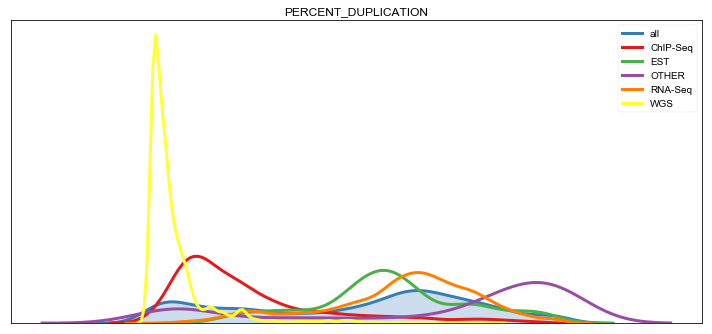

In [12]:
picard_mark = store.select('prealn/workflow/markduplicates', 'srr == srrs')['PERCENT_DUPLICATION'].to_frame()
picard_mark = picard_mark.groupby(level='srx').mean()

make_plot(picard_mark, 'PERCENT_DUPLICATION')

### Fastq Screen

For QC we used Fastq Screen to identify potential
contaminants.
I also used Fastq Screen to align to the rRNA reference.
rRNA is a
major part of total RNA.
Typically in RNA-Seq libraries we use a poly(A)
selection or ribosomal depletion to limit the amount of reads going to rRNA.
However, typically rRNA tend to be seen in RNA-Seq libraries.
The plot belows
demonstrate this showing that some libraries are very effect at removing rRNA.
But compared to WGS, ChIP-Seq, and EST the RNA-Seq distribution has a heavy tail
showing samples that have larger amounts of rRNA reads.

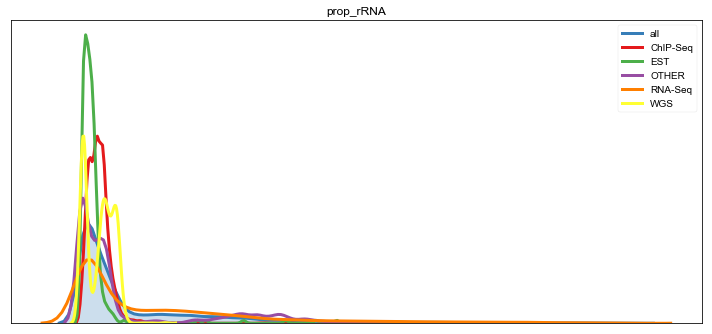

In [13]:
fastq_screen_cols = [
    'multiple_hits_multiple_libraries_count',
    'multiple_hits_one_library_count',
    'one_hit_multiple_libraries_count',
    'one_hit_one_library_count',
    'reads_processed_count',
]

fastq_screen =  store.select('prealn/workflow/fastq_screen', 'srr == srrs & reference == rRNA', columns=fastq_screen_cols)
fastq_screen = fastq_screen.groupby(level='srx').sum()
fastq_screen = (fastq_screen[fastq_screen_cols[:-1]].sum(axis=1) /  fastq_screen[fastq_screen_cols[-1]]).to_frame()
fastq_screen.columns = ['prop_rRNA']

make_plot(fastq_screen, 'prop_rRNA')

### Samtools Idxstats

Samtools Idxstats counts the number of reads mapping to
each chromosome.
Here I pull out only the major chromosomes and ignore the
scaffolds.
I am not sure if any of these are very useful for library strategy
selection.
Perhaps chrY could be useful for separating EST/RNA-seq from WGS and
ChIP-Seq.
Gene from the Y are only expressed in the testis, so testis RNA-Seq
samples would also show this expression.

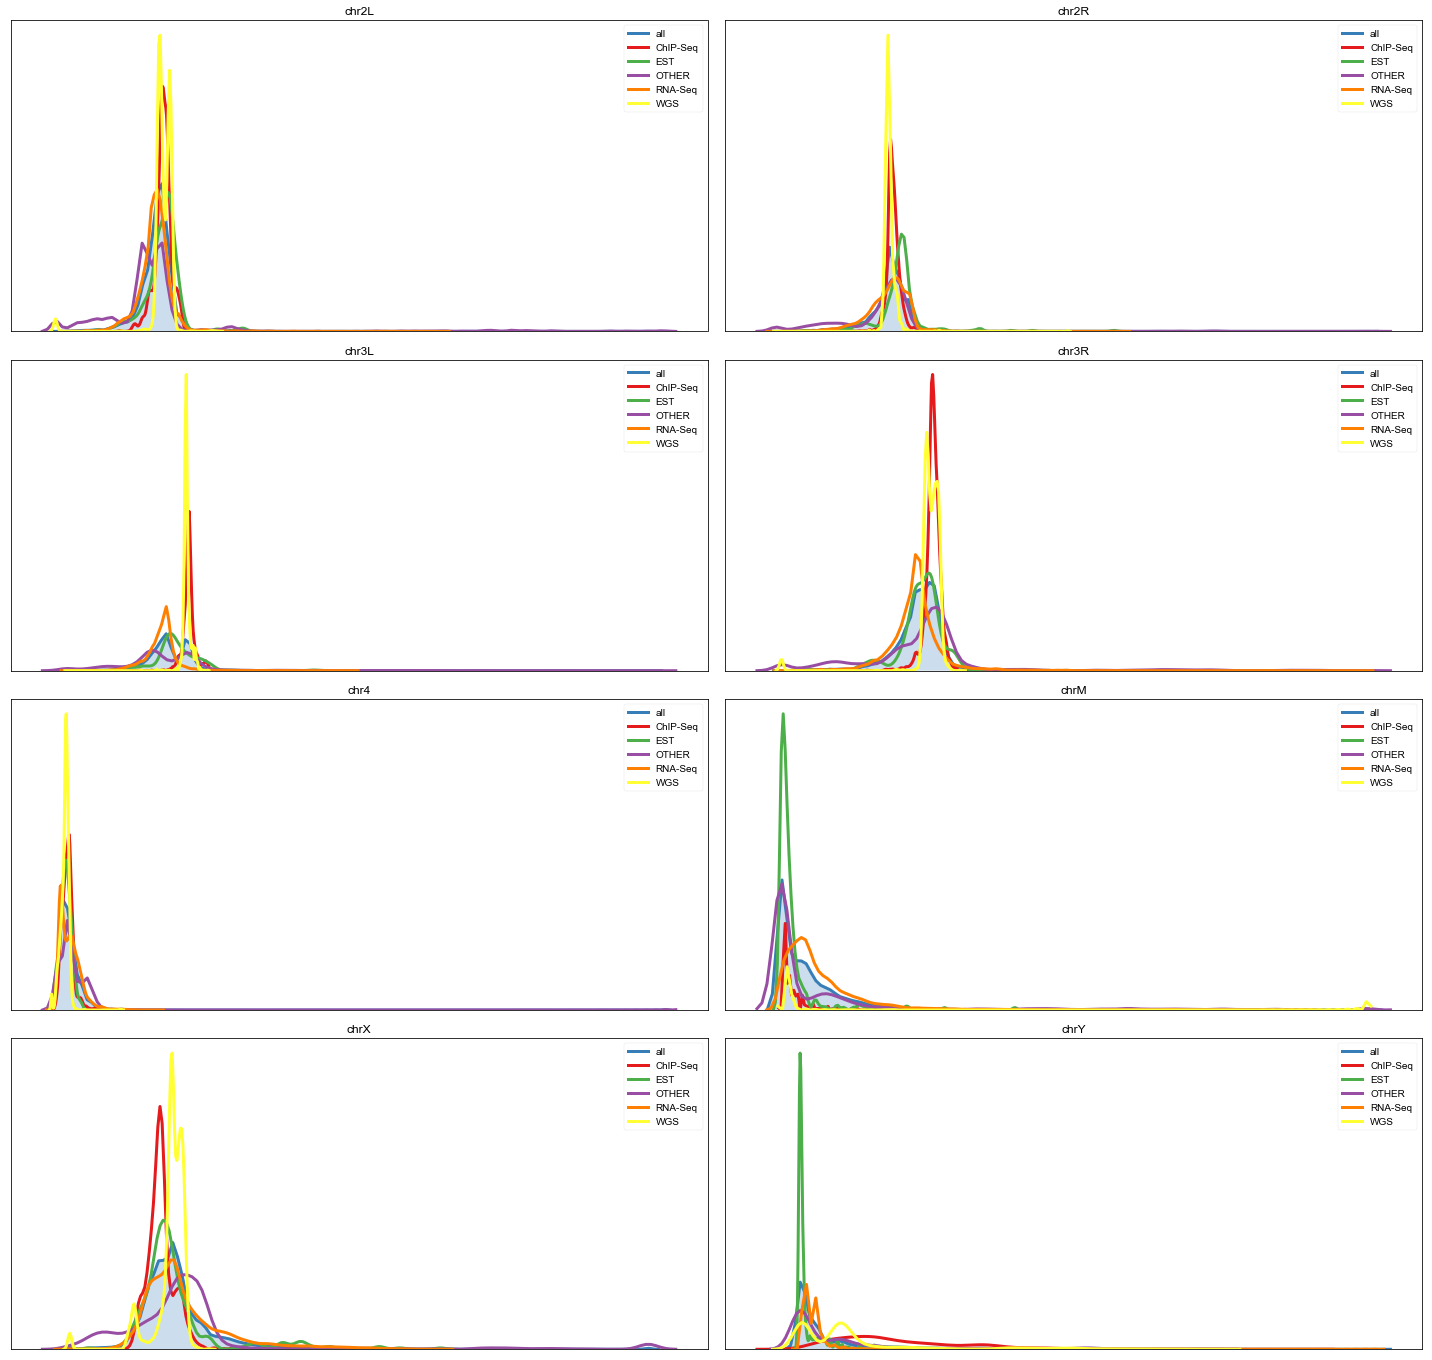

In [14]:
# Parse idxstats and store parsed form for later use
if store.__contains__('prealn/analysis/idxstats'):
    _srxs = store['prealn/analysis/idxstats'].index.get_level_values('srx').tolist()
else:
    _srxs = []

@delayed
def get_idxstats(srx):
    MAJOR_CHROMs = ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY', 'chrM']
    df = pd.read_parquet(f'../output/prealn-wf/samtools_idx_stats/{srx}.parquet')
    return df.loc[MAJOR_CHROMs].reset_index().set_index(['srx', 'srr'])[['chrom', '# mapped reads']]

lazy = []
for srx in store['prealn/merge_passed'].srx.unique().tolist():
    if srx in _srxs:
        # Already parsed so skip
        continue

    lazy.append(get_idxstats(srx))

futures = client.compute(lazy)
if len(futures) > 0:
    idxstats = pd.concat(client.gather(futures))
    idxstats = idxstats.pivot_table(columns='chrom', values='# mapped reads', index=['srx', 'srr'], aggfunc='first')
    store.append('prealn/analysis/idxstats', idxstats, format='t', data_columns=True)

idxstats = store.select('prealn/analysis/idxstats', 'srr == srrs')

idxstats = idxstats.groupby(level='srx').sum()
total = idxstats.sum(axis=1)
idxstats = (idxstats.T / total).T

cols = idxstats.columns

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(cols):
    make_plot(idxstats, col, axes[i])

### Junction Counts

The final metric explored here is looking at junction
counts.
Junctions are based on the FlyBase r6.11 reference.
Again we only expect
to see junction counts in RNA-Seq and EST because they should require splicing.
Interesting, WGS has a second shoulder suggesting an increase in junction
counts.
Don't know if these are misclassified samples or RNA contamination.

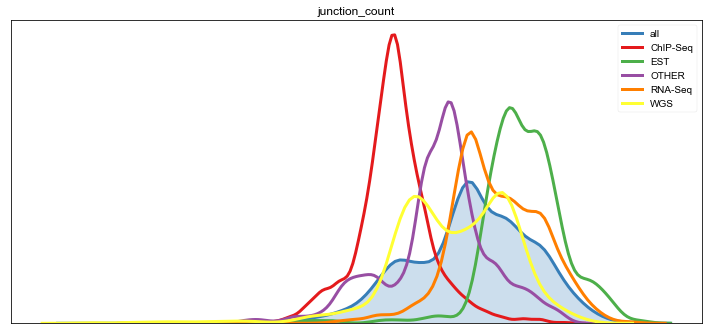

In [15]:
if store.__contains__('prealn/analysis/junction_counts'):
    _srxs = store['prealn/analysis/junction_counts'].index.get_level_values('srx').tolist()
else:
    _srxs = []

@delayed
def get_juncs(srx):
    junc = pd.read_parquet(f'../output/prealn-wf/junction_counts/{srx}.parquet')
    return junc.groupby(['srx', 'srr'])['count'].sum()

lazy = []
for srx in store['prealn/merge_passed'].srx.unique().tolist():
    if srx in _srxs:
        # Already parsed
        continue
    lazy.append(get_juncs(srx))

futures = client.compute(lazy)
if len(futures) > 0:
    juncs = pd.concat(client.gather(futures)).to_frame()
    juncs.columns = ['junction_count']
    store.append('prealn/analysis/junction_counts', juncs, format='t', data_columns=True)

juncs = store.select('prealn/analysis/junction_counts', 'srr == srrs')
juncs = juncs.groupby(level='srx').sum()

make_plot(np.log10(juncs), 'junction_count')

## Merge Features

In [16]:
df = pd.concat([
    feature_assigned,
    picard_collect,
    gb_cv,
    picard_mark,
    fastq_screen,
    idxstats,
    juncs
], axis=1)

In [17]:
display(Markdown('There are {:,} SRXs with technical metadata features processed.'.format(len(df))))
df.head()

There are 16,587 SRXs with technical metadata features processed.

,prop_features_assigned,PCT_CODING_BASES,PCT_UTR_BASES,PCT_INTRONIC_BASES,PCT_INTERGENIC_BASES,MEDIAN_CV_COVERAGE,MEDIAN_5PRIME_BIAS,MEDIAN_3PRIME_BIAS,cv_5Prime,cv_middle,...,prop_rRNA,chr2L,chr2R,chr3L,chr3R,chr4,chrM,chrX,chrY,junction_count
srx,,,,,,,,,,,,,,,,,,,,,
DRX000998,0.223712,0.201040,0.093099,0.384424,0.321436,0.322389,0.914538,0.707143,0.059553,0.018252,...,0.022721,0.169001,0.203114,0.210767,0.245932,0.008812,0.000844,0.140438,0.021091,100628
DRX000999,0.155713,0.152328,0.110122,0.414077,0.323473,0.599668,0.961241,0.977702,0.019702,0.028923,...,0.060222,0.173957,0.202502,0.216812,0.245042,0.013288,0.011725,0.113650,0.023023,16138
DRX001000,0.154187,0.140894,0.111744,0.413430,0.333932,0.304633,0.999818,0.992605,0.015856,0.017735,...,0.018531,0.174999,0.199659,0.216903,0.243557,0.013621,0.013720,0.114175,0.023366,195494
DRX001001,0.158842,0.145211,0.112361,0.417173,0.325256,0.388005,1.006289,1.014340,0.014362,0.019057,...,0.021481,0.174414,0.200328,0.217281,0.244904,0.013929,0.013184,0.113046,0.022914,45207
DRX012753,0.549039,0.306239,0.672499,0.011629,0.009632,2.010122,4.258460,0.421529,0.464225,0.325211,...,0.123378,0.103755,0.155586,0.212412,0.163454,0.007750,0.217510,0.139302,0.000231,31511332


In [18]:
store.append('prealn/analysis/tech_metadata_features', df, format='t', data_columns=True, append=False)

In [19]:
store.close()